In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [2]:
## Load dataset
data_path = "../../../Rings_2D"
OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()

NUM_DATASETS, N, D = OB.shape

SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))
NUM_EPOCHS = 1000
NUM_HIDDEN = 32
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')

RADI = torch.ones(1) * 2.0
NOISE_SIGMA = torch.ones(1) * 0.1
lg2pi = torch.ones(1) * 2 * math.pi
if CUDA:
    RADI = RADI.cuda().to(DEVICE)
    NOISE_SIGMA = NOISE_SIGMA.cuda().to(DEVICE)
    lg2pi = lg2pi.cuda().to(DEVICE)

In [3]:
from local_enc_angle import *
from decoder import *
# initialization
enc_angle = Enc_angle(D, NUM_HIDDEN, CUDA, DEVICE)
dec_x = Dec_x(2, NUM_HIDDEN, CUDA)

if CUDA:
    enc_angle.cuda().to(DEVICE)
    dec_x.cuda().to(DEVICE)
optimizer_phi =  torch.optim.Adam(list(enc_angle.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
optimizer_theta =  torch.optim.Adam(list(dec_x.parameters()), lr=LEARNING_RATE, betas=(0.9, 0.99))

In [ ]:
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    LOSS_phi = 0.0
    LOSS_theta = 0.0
    ELBO = 0.0
    EUBO = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer_phi.zero_grad()
        optimizer_theta.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = OB[batch_indices]
        state = STATE[batch_indices]
        mu = MU[batch_indices]
        mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)
        shuffled = shuffler(torch.cat((ob, state), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
        
        if CUDA:
            shuffled = shuffled.cuda().to(DEVICE)
            mu = mu.cuda().to(DEVICE)
        ob = shuffled[:, :, :, :2]
        state = shuffled[:, :, :, 2:]
        q, p = enc_angle(ob, state, mu)
        angle = p['angles'].value * 2 * math.pi
        p_recon = dec_x(ob, state, mu, angle, NOISE_SIGMA)
#         ll = ll_angle(ob, state, angle, mu, RADI, NOISE_SIGMA, cluster_flag=False)
        ll = p_recon['likelihood'].log_prob.sum(-1)
        log_w = p['angles'].log_prob.sum(-1) - lg2pi - (q['angles'].log_prob.sum(-1) - lg2pi) + ll
        w = torch.softmax(log_w, 0).detach()
        loss_phi = (w * (- q['angles'].log_prob.sum(-1) + lg2pi)).sum(0).sum(-1).mean()
        loss_theta = (w * (- ll)).sum(0).sum(-1).mean()
        elbo = log_w.sum(-1).mean()
        eubo = (w * log_w).sum(0).sum(-1).mean()
        loss_phi.backward()
        optimizer_phi.step()
        loss_theta.backward()
        optimizer_theta.step()                      
        LOSS_phi += loss_phi
        LOSS_theta += loss_theta
        ELBO += elbo
        EUBO += eubo
    time_end = time.time()
    print('epoch=%d, eubo=%.4f, elbo=%.4f, loss_phi=%.4f, loss_theta=%.4f (%ds)' % (epoch,  EUBO / NUM_BATCHES, ELBO / NUM_BATCHES, LOSS_phi / NUM_BATCHES, LOSS_theta / NUM_BATCHES, time_end - time_start))

epoch=0, eubo=-6284.6582, elbo=-9229.7080, loss_phi=460.7910, loss_theta=4860.4932 (0s)
epoch=1, eubo=-6299.0947, elbo=-9173.3115, loss_phi=448.8914, loss_theta=4863.0303 (0s)
epoch=2, eubo=-6319.7974, elbo=-9263.6582, loss_phi=461.7047, loss_theta=4896.5444 (0s)
epoch=3, eubo=-6280.2422, elbo=-9137.2607, loss_phi=446.4279, loss_theta=4841.7153 (0s)
epoch=4, eubo=-6281.7598, elbo=-9147.6670, loss_phi=452.2589, loss_theta=4849.0610 (0s)
epoch=5, eubo=-6294.7700, elbo=-9161.6514, loss_phi=452.7216, loss_theta=4862.5356 (0s)
epoch=6, eubo=-6288.7700, elbo=-9147.4023, loss_phi=455.6811, loss_theta=4859.4951 (0s)
epoch=7, eubo=-6294.5273, elbo=-9129.5078, loss_phi=451.5497, loss_theta=4861.1221 (0s)
epoch=8, eubo=-6305.2104, elbo=-9174.2363, loss_phi=459.3544, loss_theta=4879.6099 (0s)
epoch=9, eubo=-6280.3813, elbo=-9090.1299, loss_phi=448.8855, loss_theta=4844.3110 (0s)
epoch=10, eubo=-6291.5898, elbo=-9130.3105, loss_phi=455.6082, loss_theta=4862.2441 (0s)
epoch=11, eubo=-6283.5332, elbo

In [5]:
def plot_rings_v2(obs, states, recon_mu, K, bound):
    colors = ['r', 'b', 'g', 'k', 'y']
    assignments = states.argmax(-1)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    for k in range(K):
        obs_k = obs[np.where(assignments==k)]
        recon_mu_k = recon_mu[np.where(assignments==k)]
        ax.scatter(obs_k[:,0], obs_k[:, 1], s=5, c=colors[k], alpha=0.8)
        ax.scatter(recon_mu_k[:,0], recon_mu_k[:, 1], s=5, c='k', alpha=0.2)
    ax.set_xlim([-bound, bound])
    ax.set_ylim([-bound, bound])

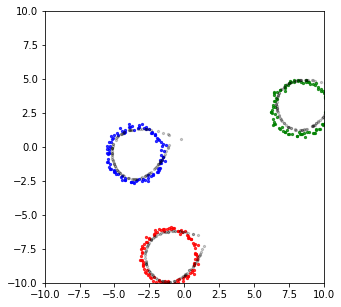

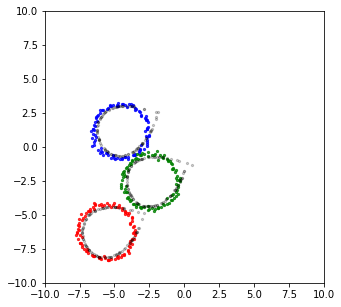

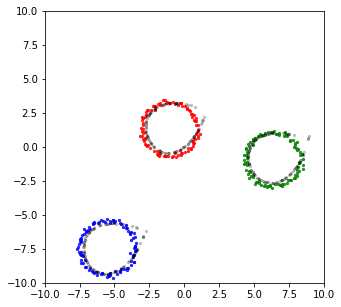

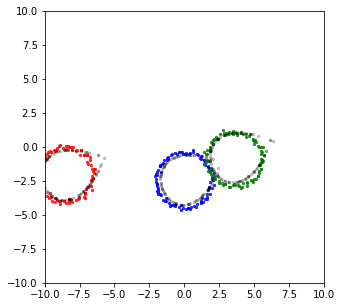

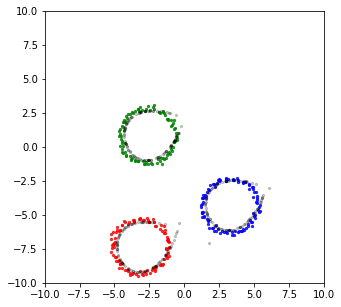

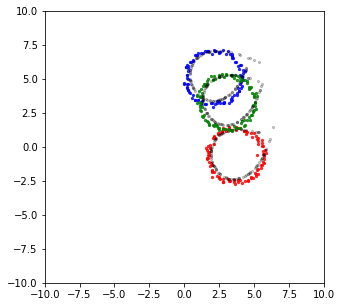

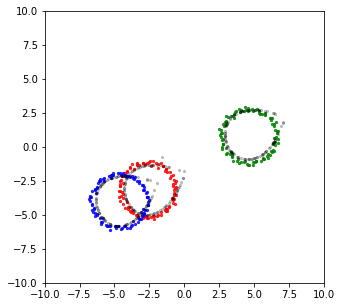

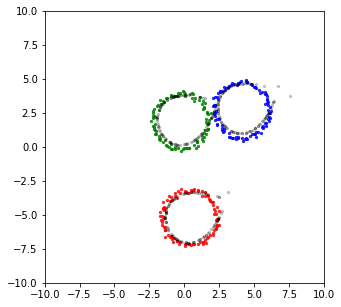

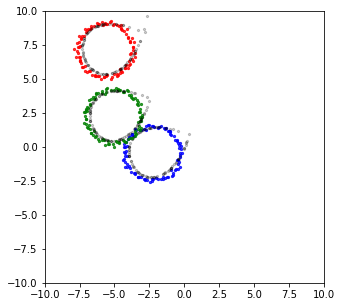

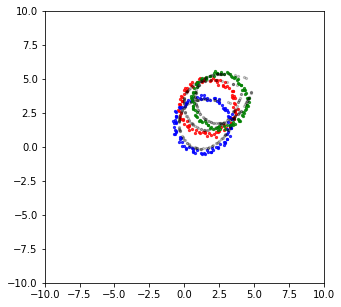

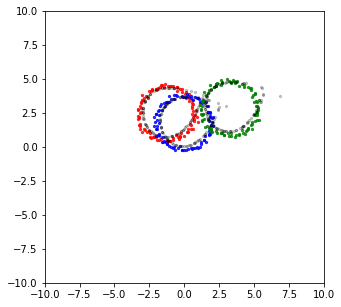

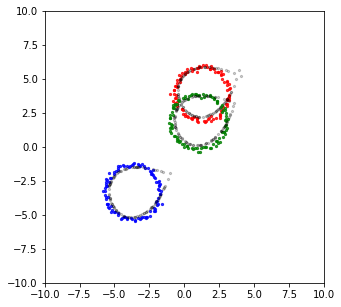

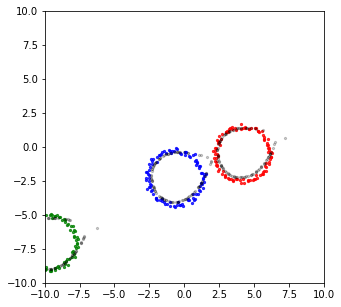

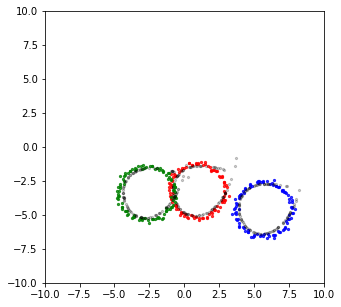

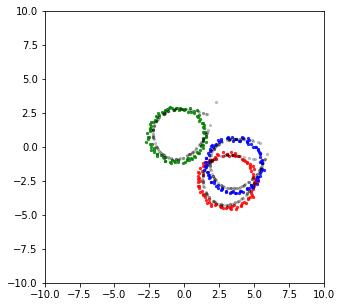

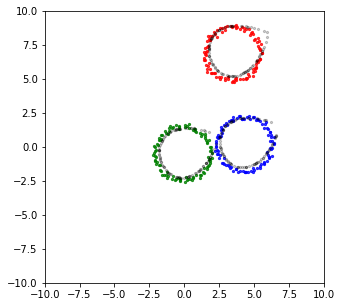

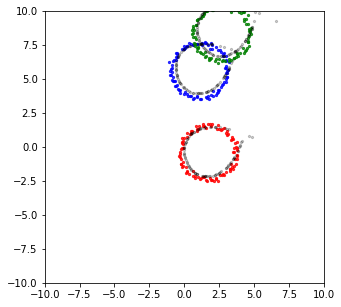

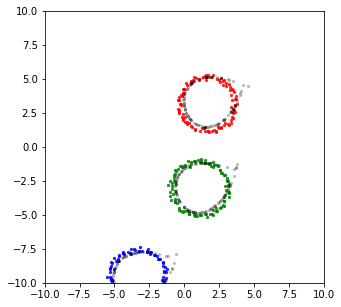

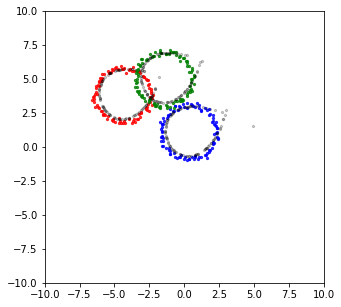

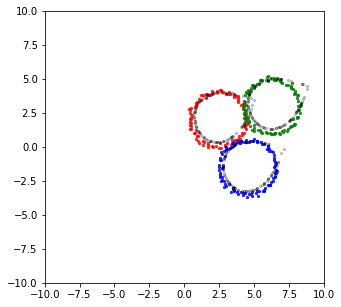

In [6]:
indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
ob = OB[batch_indices]
state = STATE[batch_indices]
mu = MU[batch_indices]
mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)
shuffled = shuffler(torch.cat((ob, state), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    shuffled = shuffled.cuda().to(DEVICE)
    mu = mu.cuda().to(DEVICE)
ob = shuffled[:, :, :, :2]
state = shuffled[:, :, :, 2:]
q, p = enc_angle(ob, state, mu)
angle = q['angles'].value * 2 * math.pi
p_recon = dec_x(ob, state, mu, angle, NOISE_SIGMA)
recon_mu = p_recon['likelihood'].dist.loc.cpu().data.numpy()
for i in range(BATCH_SIZE):
    plot_rings_v2(ob[0, i].cpu().data.numpy(), state[0, i].cpu().data.numpy(), recon_mu[0, i], 3, 10)


In [ ]:
for i in range(BATCH_SIZE):
    angle_b_inferred = angle[0, i, :, 0].cpu().data.numpy()
    angle_b_true = angle_true[0, i].cpu().data.numpy()
    plt.scatter(angle_b_inferred, angle_b_true)
    plt.gca().set_aspect('equal')
    plt.show()
    

In [ ]:
from torch.distributions.beta import Beta
dist = Beta(torch.ones(1),torch.ones(1))
samples = dist.sample((1000,))
log_pdf = dist.log_prob(samples)

In [ ]:
plt.plot(samples.data.numpy(), log_pdf.exp().data.numpy())

In [ ]:
samples.shape